In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from sklearn.metrics import auc,accuracy_score,precision_score,recall_score,classification_report,confusion_matrix,roc_auc_score,roc_curve
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn import model_selection
import warnings
warnings.filterwarnings('ignore')
from imblearn.under_sampling import RandomUnderSampler, ClusterCentroids,TomekLinks,NeighbourhoodCleaningRule,NearMiss

def down_sampling(X,y,down_sampling_type,info):
    '''refer : https://towardsdatascience.com/sampling-techniques-for-extremely-imbalanced-data-part-i-under-sampling-a8dbc3d8d6d8'''
    
    #random under sampling
    if down_sampling_type == 'random':
        sampler = RandomUnderSampler(sampling_strategy = 15/85,random_state=0)
        X_ds, y_ds = sampler.fit_sample(X, y)
        if info:
            print('After random down sampling {}'.format(Counter(y_ds)))
        return X_ds,y_ds
    
    #nearmiss under sampling
    if down_sampling_type == 'nearmiss':
        sampler = NearMiss(sampling_strategy = 15/85,random_state=0)
        X_ds, y_ds = sampler.fit_sample(X, y)
        if info:
            print('After nearmiss down sampling {}'.format(Counter(y_ds)))        
    return X_ds,y_ds

#------------------------------------------------------------------------
    
def up_sampling(X,y,info):
    
    #up sampling
    sm = SMOTE(sampling_strategy = 30/70,random_state=0 )
    X_us, y_us = sm.fit_sample(X, y)
    if info:
        print('After SMOTE up sampling {}'.format(Counter(y_us)))
    return X_us,y_us

#------------------------------------------------------------------------
    
def re_sampling(X,y,info,sampling_type,down_sampling_type):
    
    if sampling_type=='none':
        if info:
            print('split as in original data {}'.format(Counter(y)))
        return X,y

    if sampling_type=='down_sampling':
        X_ds,y_ds = down_sampling(X,y,down_sampling_type=down_sampling_type,info=info)
        return X_ds,y_ds
    
    if sampling_type=='up_sampling':
        X_us,y_us = up_sampling(X,y,info=info)
        return X_us,y_us
    
    if sampling_type=='hybrid':
        X_ds,y_ds = down_sampling(X,y,down_sampling_type=down_sampling_type,info=info)
        X_hs,y_hs = up_sampling(X_ds,y_ds,info=info)
        return X_hs,y_hs

#----------------------------------------------------------------------------------

def train_test_resampled_split(X,y,info,sampling_type,down_sampling_type,test_size):  
    
    if info:
        print('Before sampling {}'.format(Counter(y)))
    X_rs,y_rs = re_sampling(X,y,info=info,sampling_type=sampling_type,down_sampling_type=down_sampling_type)
    
    
    
    X_train,X_test,y_train,y_test = train_test_split(X_rs,y_rs,test_size=test_size,random_state=0,stratify=y_rs)
    
    print('-'*50)
    
    return X_train,X_test,y_train,y_test

#----------------------------------------------------------------------------------

def cutoff_point(model,X,y,info,test_size,sampling_type,down_sampling_type,cv_search):

    X_train,X_test,y_train,y_test = train_test_resampled_split(X=X,y=y,info=info,test_size=test_size,sampling_type=sampling_type,down_sampling_type=down_sampling_type)
    
    if cv_search != True:
        model[1].fit(X_train, y_train)

    prd = model[1].predict(X_test)
    proba = model[1].predict_proba(X_test)
    
    y_pred_df = pd.DataFrame(proba)
    y_pred_1 = y_pred_df.iloc[:,1]
    y_test_df = pd.DataFrame(y_test)

    y_pred_1.reset_index(drop=True, inplace=True)
    y_test_df.reset_index(drop=True, inplace=True)

    y_pred_final = pd.concat([y_test_df,y_pred_1],axis=1)
    y_pred_final= y_pred_final.rename(columns={ 0:'readmitted',1 : 'readmitted_probability'})
    y_pred_final['predicted'] = y_pred_final.readmitted_probability.map( lambda x: 1 if x > 0.5 else 0)
   

    numbers = [float(x)/100 for x in range(100)]
    for i in numbers:
        y_pred_final[i]= y_pred_final.readmitted_probability.map( lambda x: 1 if x > i else 0)
    y_pred_final.head()

    cutoff_df = pd.DataFrame( columns = ['prob','accuracy','sensitivity','specificity','var_ssa','recall','precision','var_pra','Area Under Curve'])
    from sklearn.metrics import confusion_matrix
    
    for i in numbers:
        cm1 = confusion_matrix( y_pred_final.readmitted, y_pred_final[i] )
        total1=sum(sum(cm1))
        
        tp = cm1[0,0]
        tn = cm1[1,1]
        fp = cm1[1,0]
        fn = cm1[0,1]
        
        accuracy = (tp+tn)/total1
        
        sensi = tp/(tp+fn)
        speci = tn/(tn+fp)
        
        recall = tp/(tp+fn)
        precision = tp/(tp+fp)
        
        var_ssa = np.std([accuracy,sensi,speci])
        var_pra = np.std([accuracy,recall,precision])
        
        fpr, tpr, thresholds = roc_curve(y_pred_final.readmitted, y_pred_final[i])
        auc = metrics.auc(fpr, tpr)
        
        cutoff_df.loc[i] =[ i ,accuracy,sensi,speci,var_ssa,recall,precision,var_pra,auc]

    print('-'*50)
    print('Finding Optimal Cutoff Point based on accuracy, recall, precision')
    cutoff_df.plot.line(x='prob', y=['accuracy','recall','precision'])
    plt.show()
    optimum_pra = cutoff_df.iloc[cutoff_df['var_pra'].argmin()]
    print('Optimum cutoff probability is {0:.2f}'.format(optimum_pra[0]))
    
    optimum_accuracy = accuracy_score(y_pred_final.readmitted,y_pred_final[optimum_pra[0]])
    optimum_precision = precision_score(y_pred_final.readmitted,y_pred_final[optimum_pra[0]])
    optimum_recall = recall_score(y_pred_final.readmitted,y_pred_final[optimum_pra[0]])
    optimum_roc_auc = roc_auc_score(y_pred_final.readmitted,y_pred_final[optimum_pra[0]])
    
    print("Accuracy is {0:.2f}".format(optimum_accuracy))
    print("Precision is {0:.2f}".format(optimum_precision))
    print("Recall is {0:.2f}".format(optimum_recall))
    print("ROC_AUC Score is {0:.2f}".format(optimum_roc_auc))
    
    result_for_optimized.loc[model[0]+'_OC'] = [optimum_accuracy,optimum_precision,optimum_recall,optimum_roc_auc]
    
    print("\nClassification report\n",classification_report(y_pred_final.readmitted,y_pred_final[optimum_pra[0]]))
    print("confusion matrix \n\n", confusion_matrix(y_pred_final.readmitted,y_pred_final[optimum_pra[0]]))
    
    return cutoff_df

#----------------------------------------------------------------------------------

def plot_roc_curve(y_true,proba):
    fpr, tpr, threshold = roc_curve(y_true, proba)
    roc_auc = auc(fpr, tpr)

    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

#----------------------------------------------------------------------------------
    
def model_check(model,X,y,sampling_type,down_sampling_type,test_size=0.15,cv_search=False,info=False):
    
    print(model[0])
    print('-'*50)
    
    if cv_search :
        
        print('Data set Before resampling {}'.format(Counter(y)) if info else '')
        
        X_train,X_test,y_train,y_test, = train_test_resampled_split(X,y,test_size=test_size,sampling_type=sampling_type,down_sampling_type=down_sampling_type,info=info)
        
        print('Train set After resampling {}'.format(Counter(y_train)))
        print('Test set After resampling {}'.format(Counter(y_test)))
            
        model[1].fit(X_train, y_train)
        prd = model[1].predict(X_test)
        proba = model[1].predict_proba(X_test)[:,1]

        accuracy = accuracy_score(y_test, prd)
        precision = precision_score(y_test, prd)
        recall = recall_score(y_test, prd)
        roc_auc = roc_auc_score(y_test,proba)

        print("Accuracy is {0:.2f}".format(accuracy))
        print("Precision is {0:.2f}".format(precision))
        print("Recall is {0:.2f}".format(recall))
        print("ROC_AUC Score is {0:.2f}".format(roc_auc))
        plot_roc_curve(y_test,proba)
        print("\nClassification report\n",classification_report(y_test, prd))
        print("confusion matrix \n\n", confusion_matrix(y_test,prd)) 
        print('-'*50)
        print('best_parameters')
        print(model[1].best_params_)
        
        result.loc[model[0]] = [accuracy,precision,recall,roc_auc]

        
    else : 
    
        kf = model_selection.StratifiedKFold(n_splits=10,shuffle=True,random_state=1)
        i=1
        cv_results=[]
        cv_df = pd.DataFrame( columns = ['kfold','accuracy','recall','precision','ROC_AUC'])
        for train_index,test_index in kf.split(X,y):
            print('{} of KFold {}'.format(i,kf.n_splits))

            xtr,xte = X.loc[train_index],X.loc[test_index]
            ytr,yte = y.loc[train_index],y.loc[test_index]

            X_tr_rs,y_tr_rs = re_sampling(xtr,ytr,info=info,sampling_type=sampling_type,down_sampling_type=down_sampling_type)

            X_te_rs,y_te_rs = re_sampling(xte,yte,info=info,sampling_type=sampling_type,down_sampling_type=down_sampling_type)

            model[1].fit(X_tr_rs, y_tr_rs)
            y_pred = model[1].predict(X_te_rs)
            y_proba = model[1].predict_proba(X_te_rs)[:,1]

            accuracy = accuracy_score(y_te_rs, y_pred)
            precision = precision_score(y_te_rs, y_pred)
            recall = recall_score(y_te_rs, y_pred)
            roc_auc = roc_auc_score(y_te_rs,y_proba)
            
            cv_df.loc[i] =[ i ,accuracy,recall,precision,roc_auc]
            '''print("\nAccuracy is {0:.2f}".format(accuracy))
            print("Precision is {0:.2f}".format(precision))
            print("Recall is {0:.2f}".format(recall))
            print("ROC_AUC Score is {0:.2f}".format(roc_auc))

            plot_roc_curve(y_te_rs,y_proba)

            print("\nClassification report\n",classification_report(y_te_rs, y_pred))
            print("confusion matrix \n\n", confusion_matrix(y_te_rs,y_pred))
            print('-'*50)'''

            i+=1    

        print('\n\n',cv_df)
        print('\nAverage accuracy after k-fold = {}'.format(np.mean(cv_df['accuracy'])))
        print('Average recall after k-fold = {}'.format(np.mean(cv_df['recall'])))
        print('Average precision after k-fold = {}'.format(np.mean(cv_df['precision'])))
        print('Average ROC_AUC after k-fold = {}'.format(np.mean(cv_df['ROC_AUC'])))
    
        result.loc[model[0]] = [np.mean(cv_df['accuracy']),np.mean(cv_df['precision']),np.mean(cv_df['recall']),np.mean(cv_df['ROC_AUC'])]
    
    print('-'*50)
    print('\n')
    cutoff_df = cutoff_point(model,X,y,cv_search=cv_search,info=info,test_size=test_size,sampling_type=sampling_type,down_sampling_type=down_sampling_type)

    return 

result = pd.DataFrame(columns=['Accuracy','Precision','Recall','AUC_ROC'])
result_for_optimized = pd.DataFrame(columns=['Accuracy','Precision','Recall','AUC_ROC'])

In [2]:
data = pd.read_csv('final_data.csv')
X = data.drop('readmitted',axis=1)
y = data['readmitted']

Naive Bayes Classifier
--------------------------------------------------
1 of KFold 10
2 of KFold 10
3 of KFold 10
4 of KFold 10
5 of KFold 10
6 of KFold 10
7 of KFold 10
8 of KFold 10
9 of KFold 10
10 of KFold 10


     kfold  accuracy    recall  precision   ROC_AUC
1     1.0  0.537026  0.821218   0.375674  0.774645
2     2.0  0.568847  0.838245   0.396530  0.784482
3     3.0  0.532954  0.850229   0.376593  0.781036
4     4.0  0.566889  0.803139   0.391707  0.776435
5     5.0  0.558650  0.812296   0.387520  0.770677
6     6.0  0.568651  0.819908   0.394579  0.778357
7     7.0  0.570222  0.833661   0.396944  0.786264
8     8.0  0.566686  0.815324   0.392868  0.779937
9     9.0  0.578668  0.824492   0.401467  0.784298
10   10.0  0.574936  0.809430   0.397555  0.776271

Average accuracy after k-fold = 0.5623529865510094
Average recall after k-fold = 0.8227942810959308
Average precision after k-fold = 0.39114379154756296
Average ROC_AUC after k-fold = 0.7792401893775801
-----------------

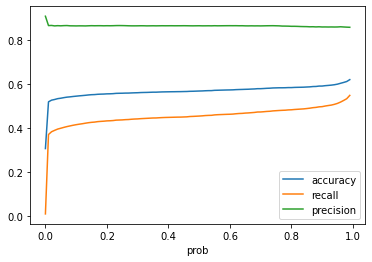

Optimum cutoff probability is 0.99
Accuracy is 0.62
Precision is 0.43
Recall is 0.79
ROC_AUC Score is 0.67

Classification report
               precision    recall  f1-score   support

           0       0.86      0.55      0.67      5349
           1       0.43      0.79      0.55      2293

    accuracy                           0.62      7642
   macro avg       0.64      0.67      0.61      7642
weighted avg       0.73      0.62      0.63      7642

confusion matrix 

 [[2930 2419]
 [ 492 1801]]


In [3]:
from sklearn.naive_bayes import GaussianNB
gnb = ['Naive Bayes Classifier',GaussianNB()]
model_check(gnb,X,y,sampling_type='hybrid',down_sampling_type='nearmiss',cv_search=False,info=False)

In [4]:
result

,Accuracy,Precision,Recall,AUC_ROC
Naive Bayes Classifier,0.562353,0.391144,0.822794,0.77924


In [5]:
result_for_optimized

,Accuracy,Precision,Recall,AUC_ROC
Naive Bayes Classifier_OC,0.619079,0.426777,0.785434,0.6666


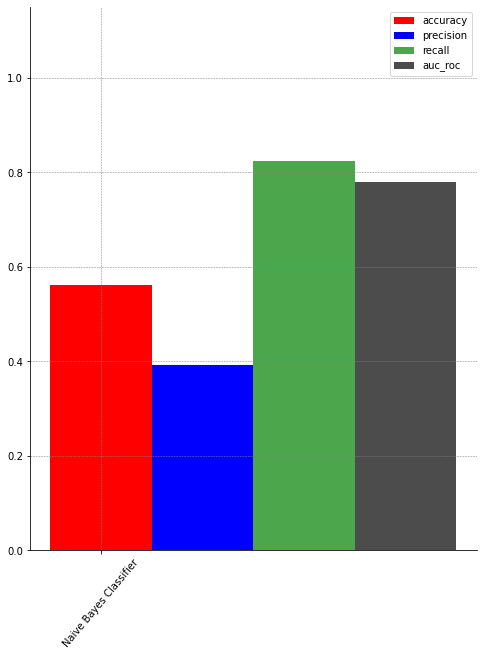

In [6]:
plt.figure(figsize=(8, 10))

ax = plt.subplot(111)

models = result.index
values = list(result['Accuracy'])
model = np.arange(len(result))

plt.bar(model, values, align='center', width = 0.1, color = 'red', label= 'accuracy')
#----------------
ax = plt.subplot(111)

models = result.index
values = list(result['Precision'])
model = np.arange(len(result))

plt.bar(model+0.1, values, align='center', width = 0.1, color = 'blue', label= 'precision')
#----------------
ax = plt.subplot(111)

models = result.index
values = list(result['Recall'])
model = np.arange(len(result))

plt.bar(model+0.2, values, align='center', width = 0.1, alpha=0.7, color = 'Green', label= 'recall')
#----------------
ax = plt.subplot(111)

models = result.index
values = list(result['AUC_ROC'])
model = np.arange(len(result))

plt.bar(model+0.3, values, align='center', width = 0.1, alpha=0.7, color = 'black', label= 'auc_roc')
plt.xticks(model, models,rotation=50,size=10)
plt.yticks(size=10)
ax.set_ylim(top=1.15)
#----------------
ax = plt.subplot(111)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.legend(loc = 1,prop={'size': 10})
ax.grid(which='major',linestyle='--', linewidth='0.5', color='grey')

plt.show() 

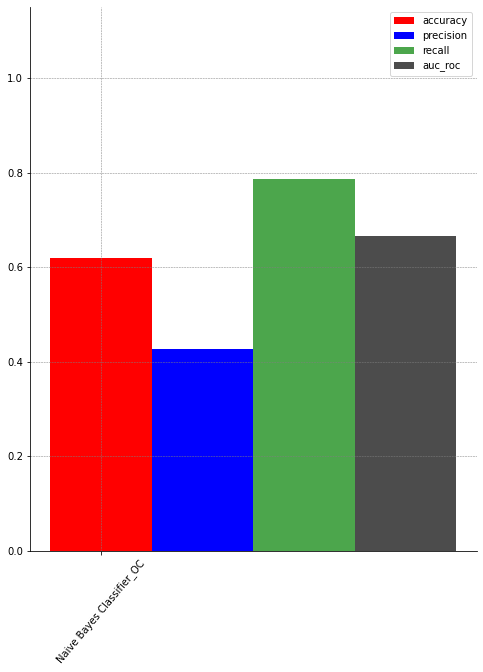

In [7]:
plt.figure(figsize=(8, 10))

ax = plt.subplot(111)

models = result_for_optimized.index
values = list(result_for_optimized['Accuracy'])
model = np.arange(len(result_for_optimized))

plt.bar(model, values, align='center', width = 0.1, color = 'red', label= 'accuracy')
#----------------
ax = plt.subplot(111)

models = result_for_optimized.index
values = list(result_for_optimized['Precision'])
model = np.arange(len(result_for_optimized))

plt.bar(model+0.1, values, align='center', width = 0.1, color = 'blue', label= 'precision')
#----------------
ax = plt.subplot(111)

models = result_for_optimized.index
values = list(result_for_optimized['Recall'])
model = np.arange(len(result_for_optimized))

plt.bar(model+0.2, values, align='center', width = 0.1, alpha=0.7, color = 'Green', label= 'recall')
#----------------
ax = plt.subplot(111)

models = result_for_optimized.index
values = list(result_for_optimized['AUC_ROC'])
model = np.arange(len(result_for_optimized))

plt.bar(model+0.3, values, align='center', width = 0.1, alpha=0.7, color = 'black', label= 'auc_roc')
plt.xticks(model, models,rotation=50,size=10)
plt.yticks(size=10)
ax.set_ylim(top=1.15)
#----------------
ax = plt.subplot(111)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.legend(loc = 1,prop={'size': 10})
ax.grid(which='major',linestyle='--', linewidth='0.5', color='grey')

plt.show() 

In [8]:
X_rs,y_rs = re_sampling(X,y,sampling_type='hybrid',down_sampling_type='nearmiss',info=False)

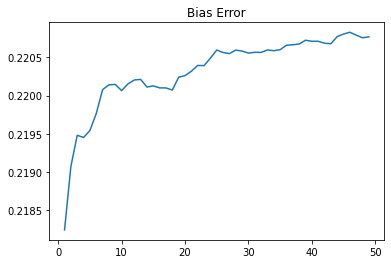

best n_estimator based on bias error =  1


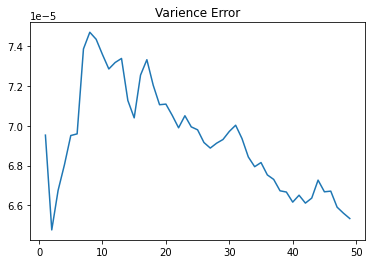

best n_estimator based on variance error =  2


In [9]:
from sklearn import model_selection
from sklearn.ensemble import BaggingClassifier
from sklearn.preprocessing import StandardScaler


Bag_bias=[]
Bag_var=[]
for val in np.arange(1,50):
    Bag=BaggingClassifier(base_estimator=gnb[1],n_estimators=val,random_state=0)
    kfold = model_selection.KFold(shuffle=True,n_splits=10,random_state=0)
    cv_results = model_selection.cross_val_score(Bag, X_rs, y_rs,cv=kfold, scoring='roc_auc')
    Bag_var.append(np.var(cv_results,ddof=1))
    Bag_bias.append(1-np.mean(cv_results))
    
x_axis=np.arange(1,50)
plt.plot(x_axis,Bag_bias)
plt.title('Bias Error')
plt.show()
print('best n_estimator based on bias error = ',(np.argmin(Bag_bias)+1))
plt.plot(x_axis,Bag_var)
plt.title('Varience Error')
plt.show()
print('best n_estimator based on variance error = ',(np.argmin(Bag_var)+1))

In [10]:
Bag_result = pd.DataFrame()
Bag_result['N-Estimators'] = np.arange(1,50)
Bag_result['Variance Error'] = Bag_var
Bag_result['Bias Error'] = Bag_bias
Bag_result.sort_values('Bias Error').head()

,N-Estimators,Variance Error,Bias Error
0,1,0.000070,0.218239
1,2,0.000065,0.219071
3,4,0.000068,0.219451
2,3,0.000067,0.219479
4,5,0.000070,0.219542


In [11]:
best_bag_est = int(Bag_result.sort_values('Bias Error').head(1)['N-Estimators'].values)
best_bag_est

1

In [12]:
Bagged_NB=['Bagged_NB',BaggingClassifier(base_estimator=gnb[1],n_estimators=best_bag_est,random_state=0)]

Bagged_NB
--------------------------------------------------
1 of KFold 10
2 of KFold 10
3 of KFold 10
4 of KFold 10
5 of KFold 10
6 of KFold 10
7 of KFold 10
8 of KFold 10
9 of KFold 10
10 of KFold 10


     kfold  accuracy    recall  precision   ROC_AUC
1     1.0  0.522294  0.864440   0.372355  0.798214
2     2.0  0.629935  0.834316   0.438554  0.812614
3     3.0  0.533150  0.877044   0.379564  0.810140
4     4.0  0.571008  0.840419   0.398079  0.807538
5     5.0  0.543154  0.858077   0.383178  0.804653
6     6.0  0.509527  0.880812   0.367486  0.800971
7     7.0  0.463956  0.912246   0.349298  0.817218
8     8.0  0.621489  0.835625   0.432249  0.812420
9     9.0  0.569633  0.859201   0.399027  0.812110
10   10.0  0.550383  0.850688   0.386607  0.800310

Average accuracy after k-fold = 0.5514529328481349
Average recall after k-fold = 0.861286766264788
Average precision after k-fold = 0.39063980948573296
Average ROC_AUC after k-fold = 0.807618808019362
--------------------------------

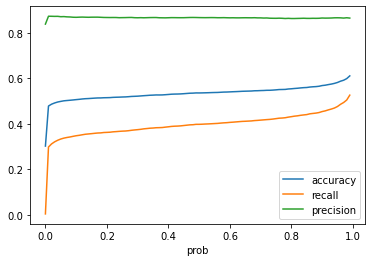

Optimum cutoff probability is 0.99
Accuracy is 0.61
Precision is 0.42
Recall is 0.81
ROC_AUC Score is 0.67

Classification report
               precision    recall  f1-score   support

           0       0.87      0.53      0.65      5349
           1       0.42      0.81      0.56      2293

    accuracy                           0.61      7642
   macro avg       0.64      0.67      0.60      7642
weighted avg       0.73      0.61      0.62      7642

confusion matrix 

 [[2817 2532]
 [ 439 1854]]


In [13]:
model_check(Bagged_NB,X,y,sampling_type='hybrid',down_sampling_type='nearmiss',test_size=0.15,cv_search=False,info=False)

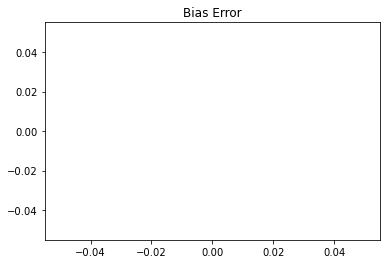

best n_estimator based on bias error =  1


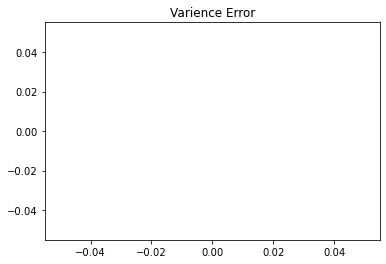

best n_estimator based on variance error =  1


In [14]:
from sklearn.ensemble import AdaBoostClassifier

Ada_nb_bias=[]
Ada_nb_var =[]
for val in np.arange(1,50):
    Ada_nb=AdaBoostClassifier(base_estimator=gnb,n_estimators=val,random_state=0)
    kfold = model_selection.KFold(shuffle=True,n_splits=10,random_state=0)
    cv_results = model_selection.cross_val_score(Ada_nb, X_rs, y_rs,cv=kfold, scoring='roc_auc')
    Ada_nb_bias.append(1-np.mean(cv_results))
    Ada_nb_var.append(np.var(cv_results,ddof=1))

x_axis=np.arange(1,50)
plt.plot(x_axis,Ada_nb_bias)
plt.title('Bias Error')
plt.show()
print('best n_estimator based on bias error = ',(np.argmin(Ada_nb_bias)+1))
plt.plot(x_axis,Ada_nb_var)
plt.title('Varience Error')
plt.show()
print('best n_estimator based on variance error = ',(np.argmin(Ada_nb_var)+1))

In [15]:
Ada_nb_result = pd.DataFrame()
Ada_nb_result['N-Estimators'] = np.arange(1,50)
Ada_nb_result['Variance Error'] = Ada_nb_var
Ada_nb_result['Bias Error'] = Ada_nb_bias
Ada_nb_result.sort_values('Bias Error').head()

,N-Estimators,Variance Error,Bias Error
0,1,NaN,NaN
1,2,NaN,NaN
2,3,NaN,NaN
3,4,NaN,NaN
4,5,NaN,NaN


In [16]:
best_boost_est = int(Ada_nb_result.sort_values('Bias Error').head(1)['N-Estimators'].values)
best_boost_est

1

In [17]:
boosted_NB=['boosted_NB',AdaBoostClassifier(base_estimator=gnb[1],n_estimators=best_boost_est,random_state=0)]

boosted_NB
--------------------------------------------------
1 of KFold 10
2 of KFold 10
3 of KFold 10
4 of KFold 10
5 of KFold 10
6 of KFold 10
7 of KFold 10
8 of KFold 10
9 of KFold 10
10 of KFold 10


     kfold  accuracy    recall  precision   ROC_AUC
1     1.0  0.543508  0.849378   0.382483  0.801594
2     2.0  0.602829  0.845449   0.419565  0.810727
3     3.0  0.548843  0.869850   0.387642  0.810421
4     4.0  0.591605  0.829300   0.410489  0.809092
5     5.0  0.605532  0.835840   0.420671  0.803133
6     6.0  0.593400  0.836280   0.412335  0.802806
7     7.0  0.612257  0.859201   0.427222  0.821727
8     8.0  0.605186  0.837590   0.420585  0.812364
9     9.0  0.600275  0.842174   0.417532  0.811470
10   10.0  0.595168  0.823183   0.412402  0.802987

Average accuracy after k-fold = 0.5898601089823895
Average recall after k-fold = 0.8428244937538093
Average precision after k-fold = 0.4110926263341835
Average ROC_AUC after k-fold = 0.8086319565773705
------------------------------

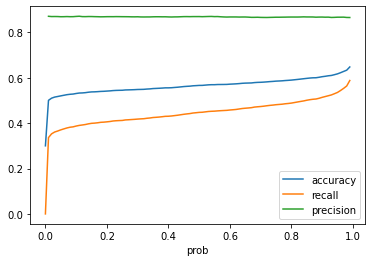

Optimum cutoff probability is 0.99
Accuracy is 0.65
Precision is 0.45
Recall is 0.79
ROC_AUC Score is 0.69

Classification report
               precision    recall  f1-score   support

           0       0.87      0.59      0.70      5349
           1       0.45      0.79      0.57      2293

    accuracy                           0.65      7642
   macro avg       0.66      0.69      0.64      7642
weighted avg       0.74      0.65      0.66      7642

confusion matrix 

 [[3144 2205]
 [ 489 1804]]


In [18]:
model_check(boosted_NB,X,y,sampling_type='hybrid',down_sampling_type='nearmiss',test_size=0.15,cv_search=False,info=False)